<u style="text-decoration:blue wavy underline"><font size="6" color="red"><b>Manufacturing Defect Detection using CNN</b></font></u>

### Summary:

*This project is to create an AI-powered computer vision system using Convolutional Neural Network(CNN) that automatically detects metal casting defects in manufacturing of submersible pump impellers, that will reduce quality control cost and improve product consistency.*

### Problem Statement:

*Manufacturing companies face challenges in maintaining consistent product quality while managing inspection costs and speed. Our task is to develop a computer vision AI system that can identify various types of defects (scratches, dents, color variations, dimensional issues, etc.) in real-time during production. The system should integrate with existing manufacturing equipment, provide instant feedback to operators, and maintain detailed quality metrics for continuous improvement.*

### Project Detail:

*1. In the manufacturing industry, reducing processing errors in the manufacturing process is important for maximizing profits.*

*2. In order to reduce processing errors, it is necessary to secure a budget for quality assurance, implement manual inspection work, and review the manufacturing process.*

*3. Particularly, the inspection process is carried out by many companies, but there are problems such as uneven accuracy denpending on inspection workers and increased labor costs.*

*4. Here we will verify whether the bottleneck of "manual inspection" can be cleared by automating the inspection process by machine learning in the manufacturing process of casting products.*

*5. Casting is a manufacturing process in which a liquid material is usually poured into a mould, which contains a hollow cavity of the desired shape, and then allowed to solidify.*

*6. There are many types of defect in casting like blow holes, pinholes, burr, shrinkage defects, mould material defects, pouring metal defects, metallurgical defects, etc.*

*7. Reason for collecting this data is casting defects! Casting defect is an undesired irregularity in a metal casting process.*

*8. For removing this defective product all industry have their quality inspection department. But the main problem is this inspection process is carried out manually. It is a very time-consuming process and due to human error, this is not 100% accurate.*

*9. It can result in the rejection of the whole order. So it creates a big loss for the company.*

### About Dataset:

*1. These photos are of top view of submersible pump impeller.*

*2. The dataset contains total 7348 image data. These all are the size of (300 X 300) pixels grey-scaled images.*

*3. In all images, augmentation already applied.*

*4. The image data is labeled with ok(normal) and def(defect/anomaly) in advance.*

*5. In addition, since it is necessary to illuminate the image in a stable condition when acquiring the image, the data was acquired based on a special lighting condition.*

*6. Dataset Link : https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product/data*

### Import libraries:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import csv
import shutil
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import torch
from transformers import pipeline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings("ignore")

In [2]:
dir_train = 'C:/Users/dasti/Python & Data Science/casting_data/casting_data/train/' 
dir_test = 'C:/Users/dasti/Python & Data Science/casting_data/casting_data/test/'

# Train Data
dir_train_def = dir_train+ 'def_front/'  # Class label: Defective
dir_train_ok = dir_train+ 'ok_front/'    # Class label: OK

# Test Data
dir_test_def = dir_test + 'def_front/' # Class label: Defective
dir_test_ok = dir_test + 'ok_front/' # Class label: OK

In [3]:
image_files_train_def = os.listdir(dir_train_def)
image_files_train_ok = os.listdir(dir_train_ok)

n = len(image_files_train_def)
m = len(image_files_train_ok)

print(f'Number of all the images in the training set is {n+m}')
print(f'Number of training defective images is {n}')
print(f'Number of training ok images is {m}')

Number of all the images in the training set is 6633
Number of training defective images is 3758
Number of training ok images is 2875


In [4]:
image_files_test_def = os.listdir(dir_test_def)
image_files_test_ok = os.listdir(dir_test_ok)

n1 = len(image_files_test_def)
m1 = len(image_files_test_ok)

print(f'Number of all the images in the test set is {n1+m1}')
print(f'Number of test defective images is {n1}')
print(f'Number of test ok images is {m1}')

Number of all the images in the test set is 715
Number of test defective images is 453
Number of test ok images is 262


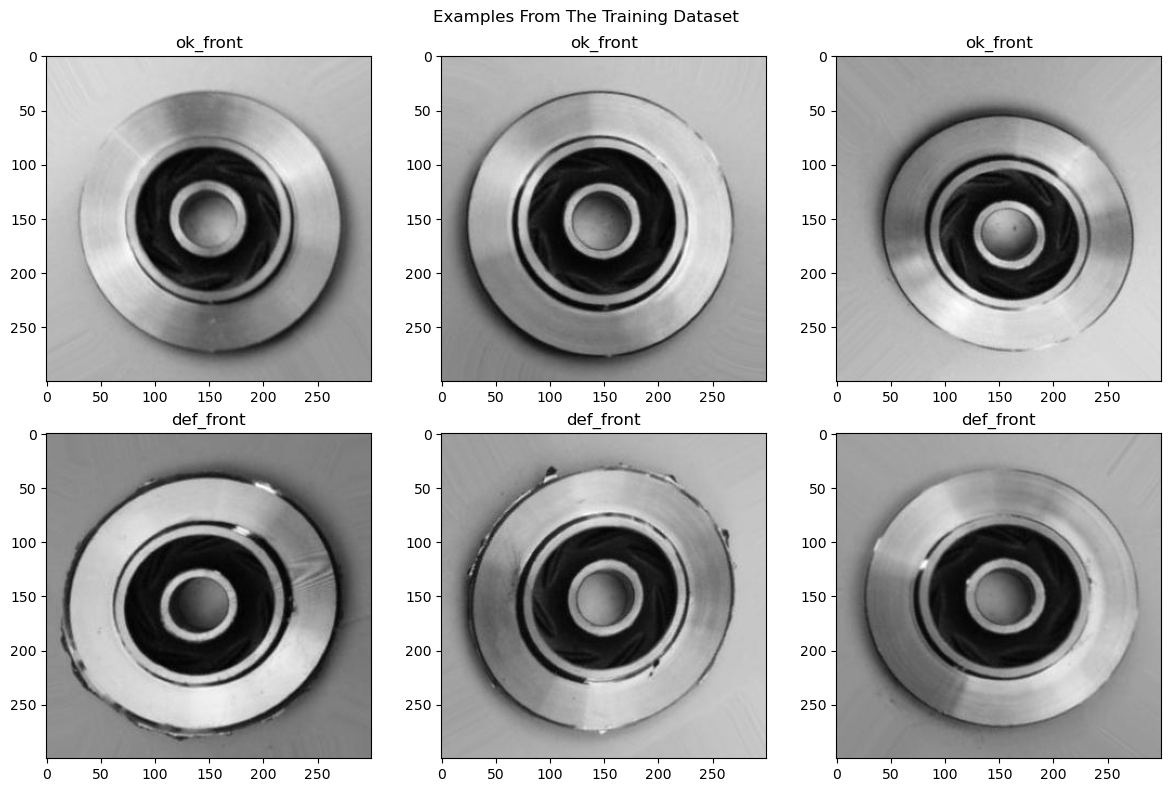

In [5]:
#Show examples of defective and ok images
#Create Function for the get a list random image files from a directory
def get_random_image_files(directory,num_files):
    files = os.listdir(directory)
    random.shuffle(files)
    return files[:num_files]


# Create a 2x3 grid for "ok_front" images
plt.figure(figsize=(12, 8))
plt.suptitle('Examples From The Training Dataset')

for i in range(3):
    plt.subplot(2, 3, i + 1)
    image_files_ok = get_random_image_files(dir_train_ok, 3)
    img = Image.open(os.path.join(dir_train_ok, image_files_ok[i]))
    plt.imshow(img)
    plt.title('ok_front')

# Create a 2x3 grid for "def_front" images
for i in range(3):
    plt.subplot(2, 3, i + 4)
    image_files_def = get_random_image_files(dir_train_def, 3)
    img = Image.open(os.path.join(dir_train_def, image_files_def[i]))
    plt.imshow(img)
    plt.title('def_front')
    
plt.tight_layout()
plt.show()

       Defective    OK
Train       3758  2875
Test         453   262


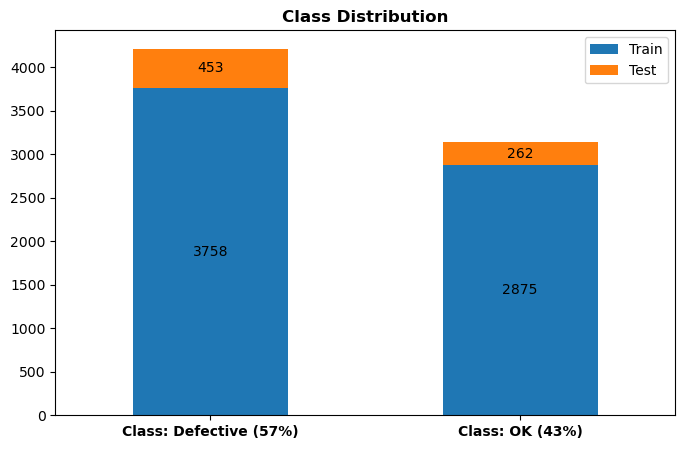

In [6]:
#Class Distribution
#Create dataframe of class distribution
n_train = [len(os.listdir(dir_train_def)), len(os.listdir(dir_train_ok))]
n_test = [len(os.listdir(dir_test_def)), len(os.listdir(dir_test_ok))]
dist_df = pd.DataFrame(
    data=[n_train, n_test],
    columns=['Defective', 'OK'],
    index=['Train', 'Test'])
print(dist_df)

# Visualize class distribution
ax = dist_df.T.plot(kind='bar', stacked=True, rot=0, figsize=(8,5))
ax.set_title('Class Distribution', loc='Center', weight='bold')
for bar in ax.patches:
    ax.text(bar.get_x()+bar.get_width()-0.25, 
            bar.get_y()+bar.get_height()/2,
            int(bar.get_height()),
            ha='center', va='center', color='black')
pct_def = 100*dist_df['Defective'].values.sum()/dist_df.values.sum()
pct_ok = 100-pct_def
ax.set_xticklabels([f'Class: Defective ({pct_def:.0f}%)',
                    f'Class: OK ({pct_ok:.0f}%)'], weight='bold')
plt.show()

In [7]:
# Define instances of ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

# Specify parameters/arguments for data generation
img_size, batch_size, rand_seed = (300, 300), 64, 0
arg_train = {'target_size': img_size,
             'color_mode': 'grayscale',
             'classes': {'ok_front': 0,
                         'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}

arg_test = {'target_size': img_size,
            'color_mode': 'grayscale',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}

# Generate data by iterating through directories
train_set = train_gen.flow_from_directory(directory=dir_train, subset='training', **arg_train)
valid_set = train_gen.flow_from_directory(directory=dir_train, subset='validation', **arg_train)
test_set = test_gen.flow_from_directory(directory=dir_test, **arg_test)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [8]:
#Define CNN Model
cnn_model = Sequential([ 
    # First block
    Conv2D(32, 3, activation='relu', padding='same', strides=2,input_shape=img_size+(1,)),
    MaxPooling2D(pool_size=2, strides=2),
    # Second block
    Conv2D(64, 3, activation='relu', padding='same', strides=2),
    MaxPooling2D(pool_size=2, strides=2),
    # Flatenning
    Flatten(),
    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')# Only 1 output
])

# Compile model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# Display summary of model architecture
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 38, 38, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23104)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,957,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,976,385 (11.35 MB)

 Trainable params: 2,976,385 (11.35 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#!pip install pydot
#!pip install pydotplus
#!pip install graphviz
#!pip install pydot_ng

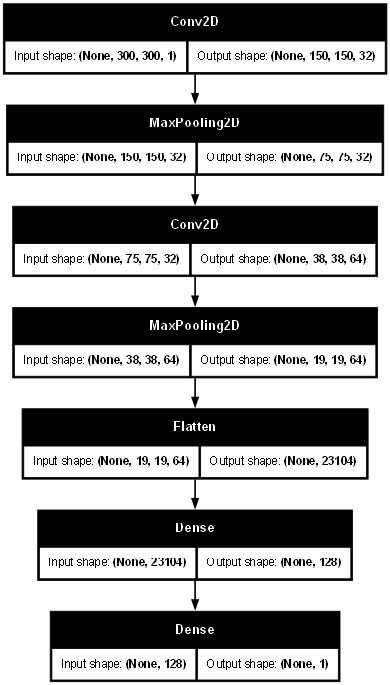

In [10]:
plot_model(cnn_model, show_shapes=True, expand_nested=True, dpi=60)

In [11]:
#Fit Model
cnn_model.fit(train_set,validation_data=valid_set,epochs=20,verbose=1)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1143s 14s/step - accuracy: 0.5830 - loss: 0.6879 - val_accuracy: 0.7383 - val_loss: 0.6020
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 122s 749ms/step - accuracy: 0.6985 - loss: 0.5617 - val_accuracy: 0.7858 - val_loss: 0.5044
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 59s 709ms/step - accuracy: 0.7931 - loss: 0.4326 - val_accuracy: 0.8688 - val_loss: 0.3398
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 384s 5s/step - accuracy: 0.8594 - loss: 0.3240 - val_accuracy: 0.9103 - val_loss: 0.2848
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 65s 786ms/step - accuracy: 0.9030 - loss: 0.2526 - val_accuracy: 0.9291 - val_loss: 0.1984
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 739s 9s/step - accuracy: 0.9244 - loss: 0.2061 - val_accuracy: 0.9525 - val_loss: 0.1571
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 72s 699ms/step - accuracy: 0.9516 - loss: 0.1464 - val_accuracy: 0.9600 - val_loss: 0.1225
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 694ms/step - accuracy: 0.9710 - loss: 0.1095 - val_accurac

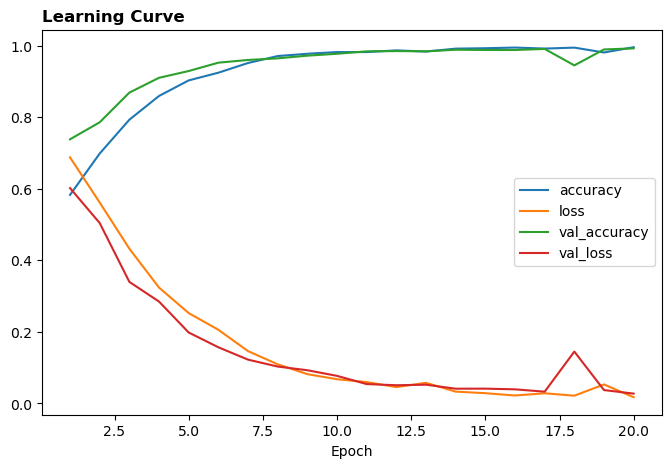

In [12]:
# Plot learning curve from model history
histo_dict = cnn_model.history.history
histo_df = pd.DataFrame(histo_dict, index=range(1,20+1))
fig, ax = plt.subplots(figsize=(8,5))
for m in histo_df.columns:
    ax.plot(histo_df.index, m, data=histo_df)
ax.set_xlabel('Epoch')
ax.set_title('Learning Curve', loc='left', weight='bold')
ax.legend()
plt.show()

In [13]:
# Make predictions on images in the test set
best_model = cnn_model
y_pred_prob = best_model.predict(test_set, verbose=1)
y_pred = (y_pred_prob >= 0.5).reshape(-1,)
y_true = test_set.classes[test_set.index_array]

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


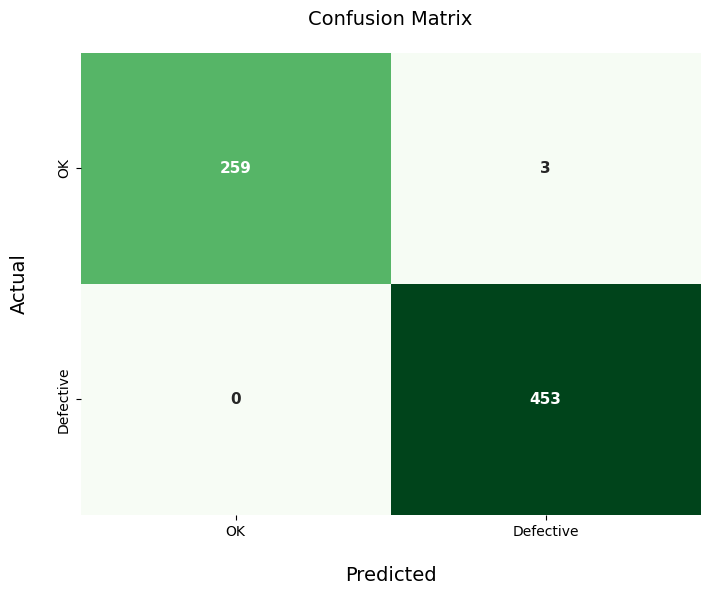

In [14]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,
                 annot_kws={'size':11, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Greens')
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')

ax.set_title("Confusion Matrix", fontsize=14, pad=20)
plt.show()

In [15]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9885    0.9942       262
           1     0.9934    1.0000    0.9967       453

    accuracy                         0.9958       715
   macro avg     0.9967    0.9943    0.9955       715
weighted avg     0.9958    0.9958    0.9958       715



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


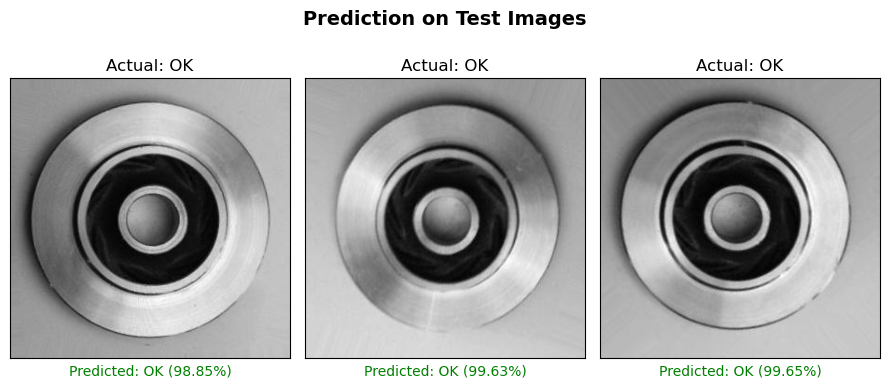

In [16]:
#Show predictions on some test images
class_map = {0: 'OK', 1: 'Defective'}
images, labels = next(iter(test_set))
images = images.reshape(batch_size,*img_size)

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
fig.suptitle('Prediction on Test Images', y=0.98, weight='bold', size=14)
for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap='gray')
    [[pred_prob]] = best_model.predict(img.reshape(1, *img_size, -1))
    pred_label = class_map[int(pred_prob>=0.5)]
    true_label = class_map[label]
    prob_class = 100*pred_prob if pred_label=='Defective' else 100*(1-pred_prob)
    ax.set_title(f'Actual: {true_label}', size=12)
    ax.set_xlabel(f'Predicted: {pred_label} ({prob_class:.2f}%)',
                  color='g' if pred_label==true_label else 'r')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


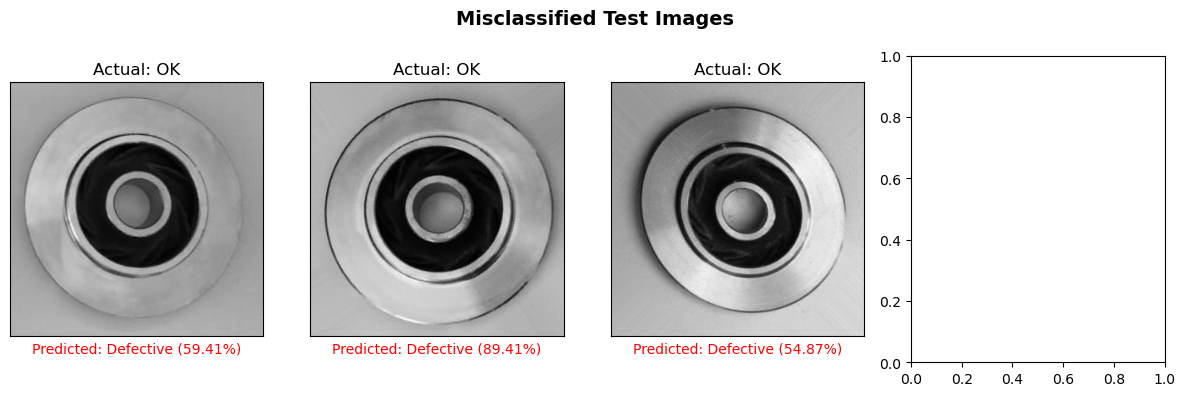

In [17]:
#Show misclassified images
misclassified = np.nonzero(y_pred != y_true)[0]
batch_num = misclassified//batch_size
image_num = misclassified%batch_size

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
fig.suptitle('Misclassified Test Images', y=0.98, weight='bold', size=14)
for ax, bnum, inum in zip(axes.flat, batch_num, image_num):
    images, labels = test_set[bnum]
    img = images[inum]
    ax.imshow(img.reshape(*img_size), cmap='gray')
    [[pred_prob]] = best_model.predict(img.reshape(1, *img_size, -1))
    pred_label = class_map[int(pred_prob>=0.5)]
    true_label = class_map[labels[inum]]
    prob_class = 100*pred_prob if pred_label=='Defective' else 100*(1-pred_prob)
    ax.set_title(f'Actual: {true_label}', size=12)
    ax.set_xlabel(f'Predicted: {pred_label} ({prob_class:.2f}%)',
                  color='g' if pred_label==true_label else 'r')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [18]:
cnn_model.save('manufacturing_defect_detection_cnn_model.keras')
best_model=tf.keras.models.load_model('manufacturing_defect_detection_cnn_model.keras')
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 38, 38, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23104)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,957,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,929,157 (34.06 MB)

 Trainable params: 2,976,385 (11.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,952,772 (22.71 MB)

In [19]:
#Identification of type of defects - mechanical damage, gas porosity, shrinkage_porosity, etc
#Apply Zero-shot classification
!pip install transformers
!pip install torch
!pip install tf-keras
!pip install hf_xet
!pip install -U ipywidgets
!pip install jupyterlab_widgets

In [20]:
# Load the zero-shot classifier pipeline with the large model
classifier = pipeline("zero-shot-image-classification", model="openai/clip-vit-large-patch14", device=0)  # device=0 for cuda:0
print("Device set to use cuda:0 - Pipeline loaded with large model successfully")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


Device set to use cuda:0 - Pipeline loaded with large model successfully


In [21]:
# Cleanup existing output directory
working_dir = "C:/Users/dasti/Python & Data Science/casting_data/working/dataset"
if os.path.exists(working_dir):
    shutil.rmtree(working_dir)
    print(f"Cleared existing directory: {working_dir}")

Cleared existing directory: C:/Users/dasti/Python & Data Science/casting_data/working/dataset


In [22]:
# Refined candidate labels based on sample analysis
candidate_labels = [
    "a grayscale photo of a circular metal casting front with mechanical damage, showing scratches, chips, or surface abrasions from machining or handling",
    "a grayscale photo of a circular metal casting front with gas porosity defect, showing small distinct round pinholes or tiny bubble-like holes on the flat ring surface",
    "a grayscale photo of a circular metal casting front with shrinkage porosity defect, showing jagged angular notches, elongated cracks, or cavity depressions on the edges or surface"
]

In [23]:
# Assuming input is read-only, we'll copy to working dir and modify there
base_input_dir = "C:/Users/dasti/Python & Data Science/casting_data/casting_data/"
working_dir = "C:/Users/dasti/Python & Data Science/casting_data/working/dataset/"

if not os.path.exists(working_dir):
    shutil.copytree(base_input_dir, working_dir)

# Folders to process
folders_to_process = [
    os.path.join(working_dir, "train/def_front"),
    os.path.join(working_dir, "test/def_front")
]

print(folders_to_process)

['C:/Users/dasti/Python & Data Science/casting_data/working/dataset/train/def_front', 'C:/Users/dasti/Python & Data Science/casting_data/working/dataset/test/def_front']


In [24]:
# Output CSV for logging results (like your screenshot)
output_csv = "C:/Users/dasti/Python & Data Science/casting_data/working/classified_defects.csv"

In [25]:
# Function to classify and return class name and score
def classify_image(image_path):
    try:
        # Load image and convert to RGB (fixes grayscale issues like in sample image)
        image = Image.open(image_path).convert("RGB")
        
        # Classify
        results = classifier(image, candidate_labels=candidate_labels)
        top_result = results[0]
        predicted_label = top_result["label"]
        score = top_result["score"]

        # Map to simple class names
        if "mechanical damage" in predicted_label:
            return "mechanical damage", score
        elif "gas porosity" in predicted_label:
            return "gas_porosity", score
        elif "shrinkage porosity" in predicted_label:
            return "shrinkage_porosity", score
        else:
            return "unknown", score
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return "ERROR", 0.0

In [26]:
# Process all defective folders
with open(output_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["image_path", "pred_desc", "pred_class", "top1_score", "top2_label", "top2_score", "accepted_auto"])
    
    for folder in folders_to_process:
        for filename in os.listdir(folder):
            if filename.lower().endswith((".jpg", ".jpeg", ".png", ".tif")):
                image_path = os.path.join(folder, filename)
                # Classify
                class_name, score = classify_image(image_path)
                writer.writerow([image_path, class_name if class_name != "ERROR" else "ERROR", 
                                 class_name if class_name != "ERROR" else "ERROR", 
                                 score if class_name != "ERROR" else "NaN", 
                                 "None", "NaN", "True" if score > 0.5 else "False"])
                # Create subfolders and move images
                if class_name != "ERROR" and class_name != "unknown":
                    subfolder = os.path.join(folder, class_name)
                    os.makedirs(subfolder, exist_ok=True)
                    new_path = os.path.join(subfolder, filename)
                    shutil.move(image_path, new_path)
                    print(f"Moved {filename} to {class_name} folder")
                else:
                    print(f"Skipped moving {filename} due to {class_name}")

Moved cast_def_0_0.jpeg to gas_porosity folder
Moved cast_def_0_1000.jpeg to shrinkage_porosity folder
Moved cast_def_0_1001.jpeg to shrinkage_porosity folder
Moved cast_def_0_1004.jpeg to gas_porosity folder
Moved cast_def_0_1007.jpeg to gas_porosity folder
Moved cast_def_0_1008.jpeg to gas_porosity folder
Moved cast_def_0_1014.jpeg to gas_porosity folder
Moved cast_def_0_1016.jpeg to shrinkage_porosity folder
Moved cast_def_0_1019.jpeg to mechanical damage folder
Moved cast_def_0_1020.jpeg to mechanical damage folder
Moved cast_def_0_1021.jpeg to gas_porosity folder
Moved cast_def_0_1025.jpeg to gas_porosity folder
Moved cast_def_0_103.jpeg to gas_porosity folder
Moved cast_def_0_1031.jpeg to gas_porosity folder
Moved cast_def_0_1037.jpeg to gas_porosity folder
Moved cast_def_0_1038.jpeg to mechanical damage folder
Moved cast_def_0_1042.jpeg to shrinkage_porosity folder
Moved cast_def_0_1043.jpeg to gas_porosity folder
Moved cast_def_0_1046.jpeg to gas_porosity folder
Moved cast_def_

In [28]:
# Count images in each class
def count_images_in_classes(folders):
    class_counts = {"mechanical damage": 0, "gas_porosity": 0, "shrinkage_porosity": 0}
    for folder in folders:
        for class_name in class_counts.keys():
            class_folder = os.path.join(folder, class_name)
            if os.path.exists(class_folder):
                class_counts[class_name] += len(os.listdir(class_folder))
    return class_counts

# Get counts for train and test
train_folder = os.path.join(working_dir, "train", "def_front")
test_folder = os.path.join(working_dir, "test", "def_front")
train_counts = count_images_in_classes([train_folder])
test_counts = count_images_in_classes([test_folder])

print("\nImage counts in train/defective_front:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} images")

print("\nImage counts in test/defective_front:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count} images")

print("\nTotal images per class across train and test:")
total_counts = {class_name: train_counts[class_name] + test_counts[class_name] for class_name in train_counts}
for class_name, count in total_counts.items():
    print(f"{class_name}: {count} images")


Image counts in train/defective_front:
mechanical damage: 1152 images
gas_porosity: 1634 images
shrinkage_porosity: 972 images

Image counts in test/defective_front:
mechanical damage: 131 images
gas_porosity: 217 images
shrinkage_porosity: 105 images

Total images per class across train and test:
mechanical damage: 1283 images
gas_porosity: 1851 images
shrinkage_porosity: 1077 images


In [44]:
import random

# Function to visualize sample images
def visualize_samples(folder, num_samples=5):
    class_folders = [os.path.join(folder, cls) for cls in ["mechanical damage", "gas_porosity", "shrinkage_porosity"] if os.path.exists(os.path.join(folder, cls))]
    plt.figure(figsize=(15, 5))
    for i, class_folder in enumerate(class_folders, start=1):
        if os.path.exists(class_folder):
            images = os.listdir(class_folder)
            if images:
                sample_image = random.choice(images)
                img_path = os.path.join(class_folder, sample_image)
                img = Image.open(img_path)
                plt.subplot(1, len(class_folders), i)
                plt.imshow(img)
                plt.title(f"{os.path.basename(class_folder)}")
                plt.axis("off")
    plt.show()


Visualizing sample images from train/defective_front:


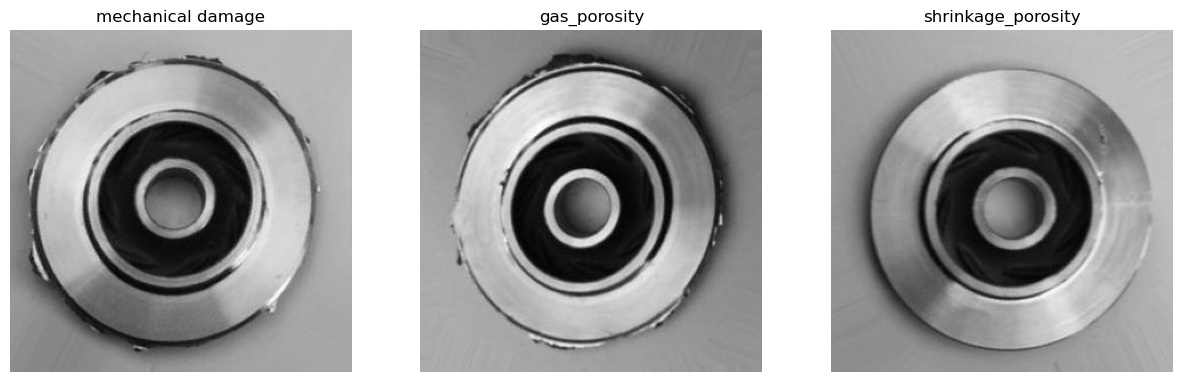


Visualizing sample images from test/defective_front:


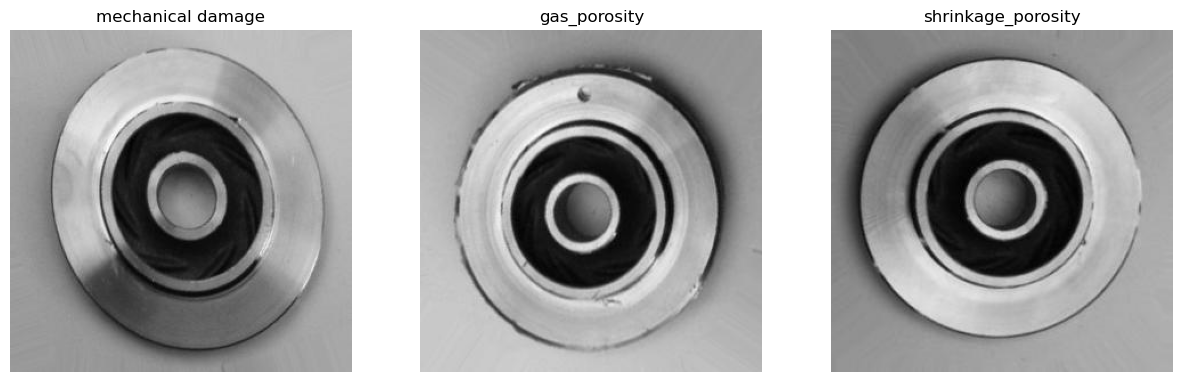

In [47]:
print("\nVisualizing sample images from train/defective_front:")
visualize_samples(train_folder)
print("\nVisualizing sample images from test/defective_front:")
visualize_samples(test_folder)

In [48]:
print("\nDistribution Check:")
total_images = sum(total_counts.values())
for class_name, count in total_counts.items():
    percentage = (count / total_images) * 100
    print(f"{class_name}: {count} images ({percentage:.1f}%)")


Distribution Check:
mechanical damage: 1283 images (30.5%)
gas_porosity: 1851 images (44.0%)
shrinkage_porosity: 1077 images (25.6%)
